In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow import keras
import glob
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from sklearn.metrics import confusion_matrix

In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"blckiris","key":"878734b7281e8b3dbe3c8d90ea93519f"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 86% 13.0M/15.1M [00:01<00:00, 14.9MB/s]
100% 15.1M/15.1M [00:01<00:00, 9.14MB/s]


In [ ]:
! unzip "brain-mri-images-for-brain-tumor-detection.zip"

Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_datase

In [ ]:
import os

# Print the current working directory
print("Current working directory:", os.getcwd())

# List all files and directories in the current working directory
print("\nFiles and directories:")
for item in os.listdir(os.getcwd()):
    print(item)

Current working directory: /content

Files and directories:
.config
kaggle.json
brain-mri-images-for-brain-tumor-detection.zip
brain_tumor_dataset
yes
no
sample_data


In [ ]:
# Import required libraries
from pathlib import Path
import pandas as pd

# Define paths for 'no' and 'yes' directories
no = ['/content/brain_tumor_dataset/no']
yes = ['/content/brain_tumor_dataset/yes']

# Initialize lists to store file paths and corresponding labels
file_p = []
labels = []

# Create a list of Path objects for each directory
# This makes it easier to manipulate and iterate over directories and files
dict_lists = [[Path(p) for p in dir_list] for dir_list in (no, yes)]

# Define class labels for the two categories
class_labels = ['no', 'yes']

# Iterate over the directories and files to collect file paths and labels
for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        # List all files in the current directory
        files = list(j.glob('*'))

        # Extend the file paths list with the paths of the current directory
        file_p.extend([str(p) for p in files])

        # Extend the labels list with the corresponding class label
        labels.extend([class_labels[i]] * len(files))

# Create a Pandas Series for file paths
file_paths_series = pd.Series(file_p, name="filepaths")

# Create a Pandas Series for labels
labels_series = pd.Series(labels, name="labels")
data = pd.concat([file_paths_series, labels_series], axis=1)
df = pd.DataFrame(data)


In [ ]:
df.head()

,filepaths,labels
0,/content/brain_tumor_dataset/no/N16.jpg,no
1,/content/brain_tumor_dataset/no/18 no.jpg,no
2,/content/brain_tumor_dataset/no/No16.jpg,no
3,/content/brain_tumor_dataset/no/no 923.jpg,no
4,/content/brain_tumor_dataset/no/15 no.jpg,no


In [ ]:
#Creating data sets for train, val and test
train_data, test_val_data = train_test_split(df, test_size=0.4, random_state=42, stratify=df.labels)
test_data, val_data = train_test_split(test_val_data, test_size=0.375, random_state=42, stratify=test_val_data.labels)

#printing their sizes
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Validation data shape: {val_data.shape}")

Training data shape: (151, 2)
Test data shape: (63, 2)
Validation data shape: (39, 2)


In [ ]:
# Function to enhance image quality using various techniques
def enhance_image(image):
    # Adjust brightness and contrast
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0)

    # Apply a sharpening filter
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    # Adjust hue, saturation, and value
    hue = image[:, :, 0]
    saturation = image[:, :, 1]
    value = image[:, :, 2]
    value = np.clip(value * 1.25, 0, 255)

    image[:, :, 2] = value

    return image

In [ ]:
# Configure ImageDataGenerator for data augmentation
data_augmentation = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    preprocessing_function=lambda image: enhance_image(image),  # Apply custom image enhancement
    rotation_range=0.3,  # Random rotation within 30 degrees
    zoom_range=0.2,  # Random zoom up to 20%
    horizontal_flip=True  # Random horizontal flip
)

In [ ]:
# Configure data generators for training, testing, and validation sets
train = data_augmentation.flow_from_dataframe(
    dataframe=train_data,  # Training data DataFrame
    x_col="filepaths",  # Column containing file paths
    y_col="labels",  # Column containing labels
    target_size=(256, 256),  # Resize images to 256x256
    color_mode='rgb',  # Use RGB color mode
    class_mode="binary",  # Binary classification
    batch_size=64,  # Batch size of 64
    shuffle=True  # Shuffle the data
)

test = data_augmentation.flow_from_dataframe(
    dataframe=test_data,
    x_col="filepaths",
    y_col="labels",
    target_size=(256, 256),
    color_mode='rgb',
    class_mode="binary",
    batch_size=64,
    shuffle=False
)

val = data_augmentation.flow_from_dataframe(
    dataframe=val_data,
    x_col="filepaths",
    y_col="labels",
    target_size=(256, 256),
    color_mode='rgb',
    class_mode="binary",
    batch_size=64,
    shuffle=False
)

Found 151 validated image filenames belonging to 2 classes.
Found 63 validated image filenames belonging to 2 classes.
Found 39 validated image filenames belonging to 2 classes.


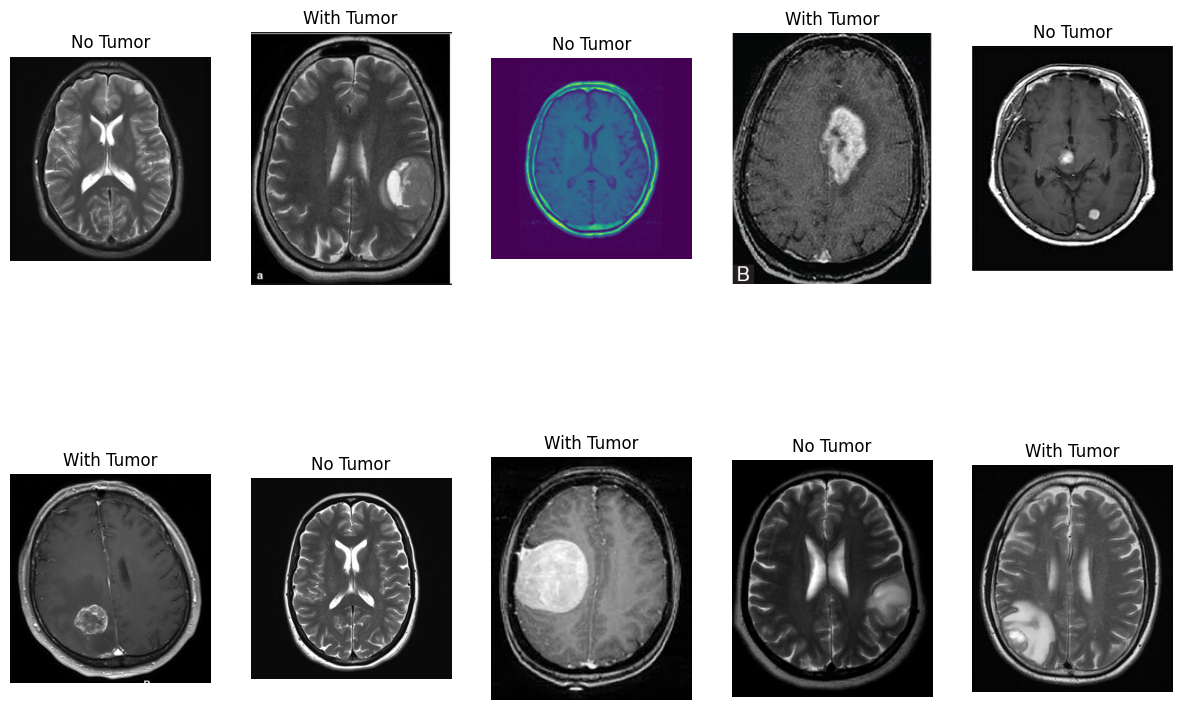

In [ ]:
# Define the number of images to display from each class
num_images_per_class = 5  # Reduced to 5 per class for better visualization

# Get class labels
class_labels = list(train.class_indices.keys())

# Plot images from each class
plt.figure(figsize=(15, 10))
for label in class_labels:
    # Get indices of images belonging to the current class
    indices = train_data[train_data['labels'] == label].index

    # Randomly sample a subset of indices if there are more than the desired number of images per class
    indices = np.random.choice(indices, min(num_images_per_class, len(indices)), replace=False)

    # Plot images
    for i, idx in enumerate(indices):
        plt.subplot(len(class_labels), num_images_per_class, len(class_labels)*i + class_labels.index(label) + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = plt.imread(train_data.loc[idx, 'filepaths'])  # Load the image
        plt.imshow(img)

        # Assign labels based on class
        if label == 'no':
            my_label = 'No Tumor'
        elif label == 'yes':
            my_label = 'With Tumor'

        plt.xlabel(my_label)
        plt.title(my_label)
        plt.axis('off')
plt.show()

In [ ]:
#CNN Model
# Define data augmentation as a Sequential model
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),  # Random horizontal flip
    keras.layers.RandomRotation(0.3),  # Random rotation up to 30 degrees
    keras.layers.RandomZoom(0.2)  # Random zoom up to 20%
])

# Early stopping callback to prevent overfitting
callback = keras.callbacks.EarlyStopping(patience=50, monitor='loss')

In [ ]:
# Define the convolutional neural network model
inputs = keras.Input(shape=(256, 256, 3))
x = keras.layers.Rescaling(1./255)(inputs)  # Normalize pixel values
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)  # Convolutional layer with ReLU activation
x = keras.layers.MaxPooling2D(pool_size=2)(x)  # Max pooling layer
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)  # Output layer with sigmoid activation

# Create the model
model = keras.Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Define early stopping callback
callback = EarlyStopping(patience=50, monitor='loss')

# Train the model
history = model.fit(
    train,
    epochs=20,
    validation_data=val,
    callbacks=[callback]
)

Epoch 1/20
3/3 [==============================] - 13s 2s/step - loss: 0.6998 - accuracy: 0.6225 - val_loss: 0.6640 - val_accuracy: 0.6154
Epoch 2/20
3/3 [==============================] - 3s 1s/step - loss: 0.6633 - accuracy: 0.6159 - val_loss: 0.6629 - val_accuracy: 0.6154
Epoch 3/20
3/3 [==============================] - 4s 1s/step - loss: 0.6632 - accuracy: 0.6159 - val_loss: 0.6610 - val_accuracy: 0.6154
Epoch 4/20
3/3 [==============================] - 3s 997ms/step - loss: 0.6639 - accuracy: 0.6159 - val_loss: 0.6624 - val_accuracy: 0.6154
Epoch 5/20
3/3 [==============================] - 3s 1s/step - loss: 0.6581 - accuracy: 0.6159 - val_loss: 0.6592 - val_accuracy: 0.6154
Epoch 6/20
3/3 [==============================] - 4s 1s/step - loss: 0.6611 - accuracy: 0.6159 - val_loss: 0.6670 - val_accuracy: 0.6154
Epoch 7/20
3/3 [==============================] - 3s 975ms/step - loss: 0.6518 - accuracy: 0.6159 - val_loss: 0.6523 - val_accuracy: 0.6154
Epoch 8/20
3/3 [==================

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                        

In [ ]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 [==============================] - 2s 2s/step - loss: 0.6150 - accuracy: 0.7302
Test Loss: 0.6149736642837524
Test Accuracy: 0.7301587462425232


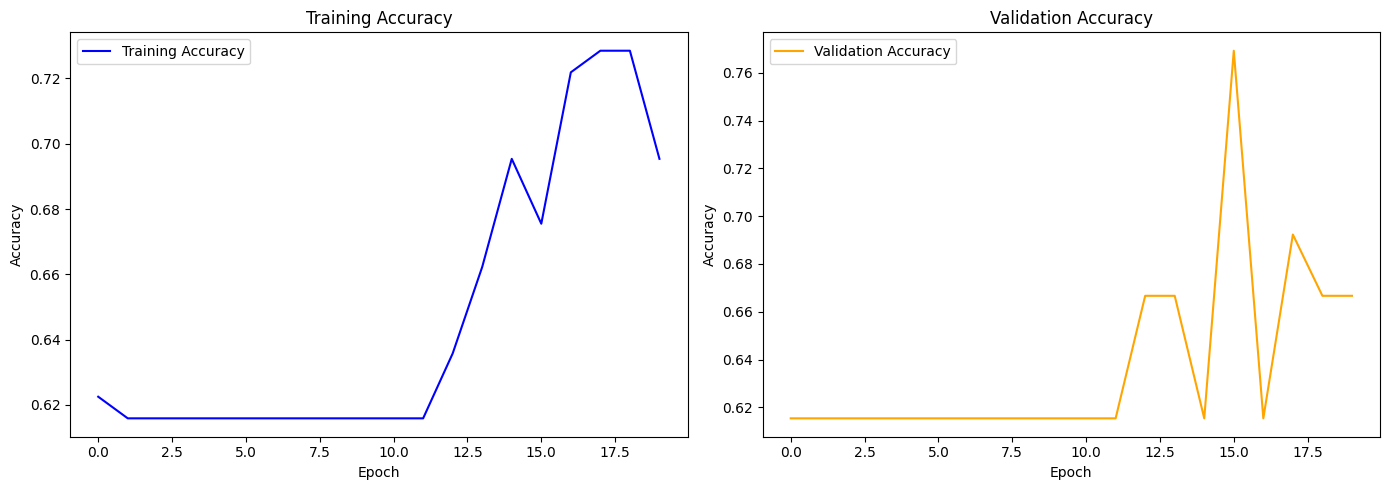

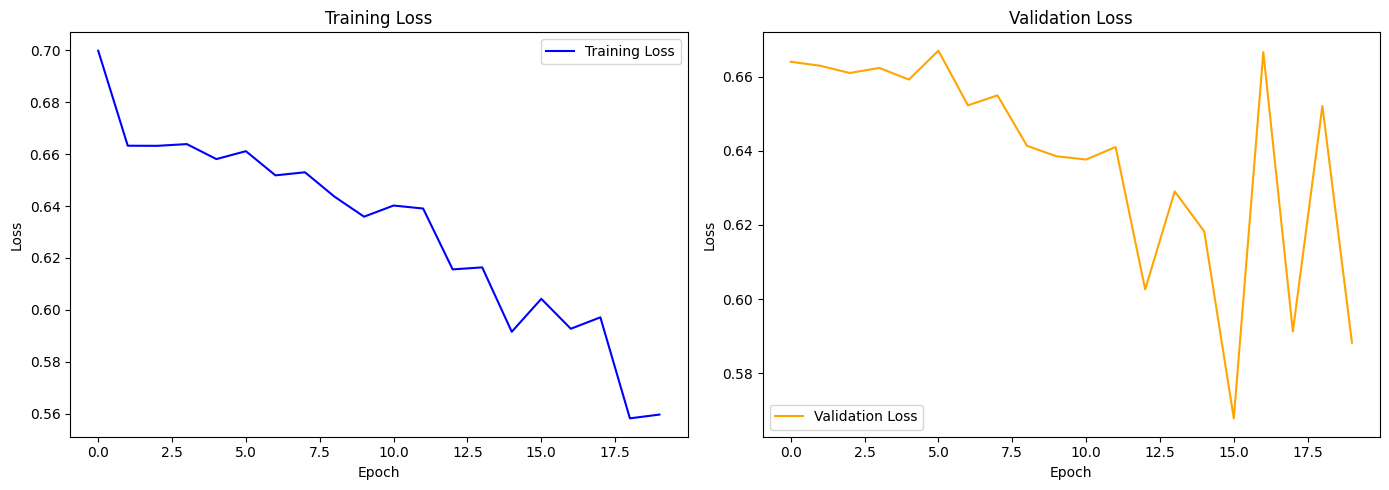

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()


# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Plot training and validation loss
plt.figure(figsize=(14, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

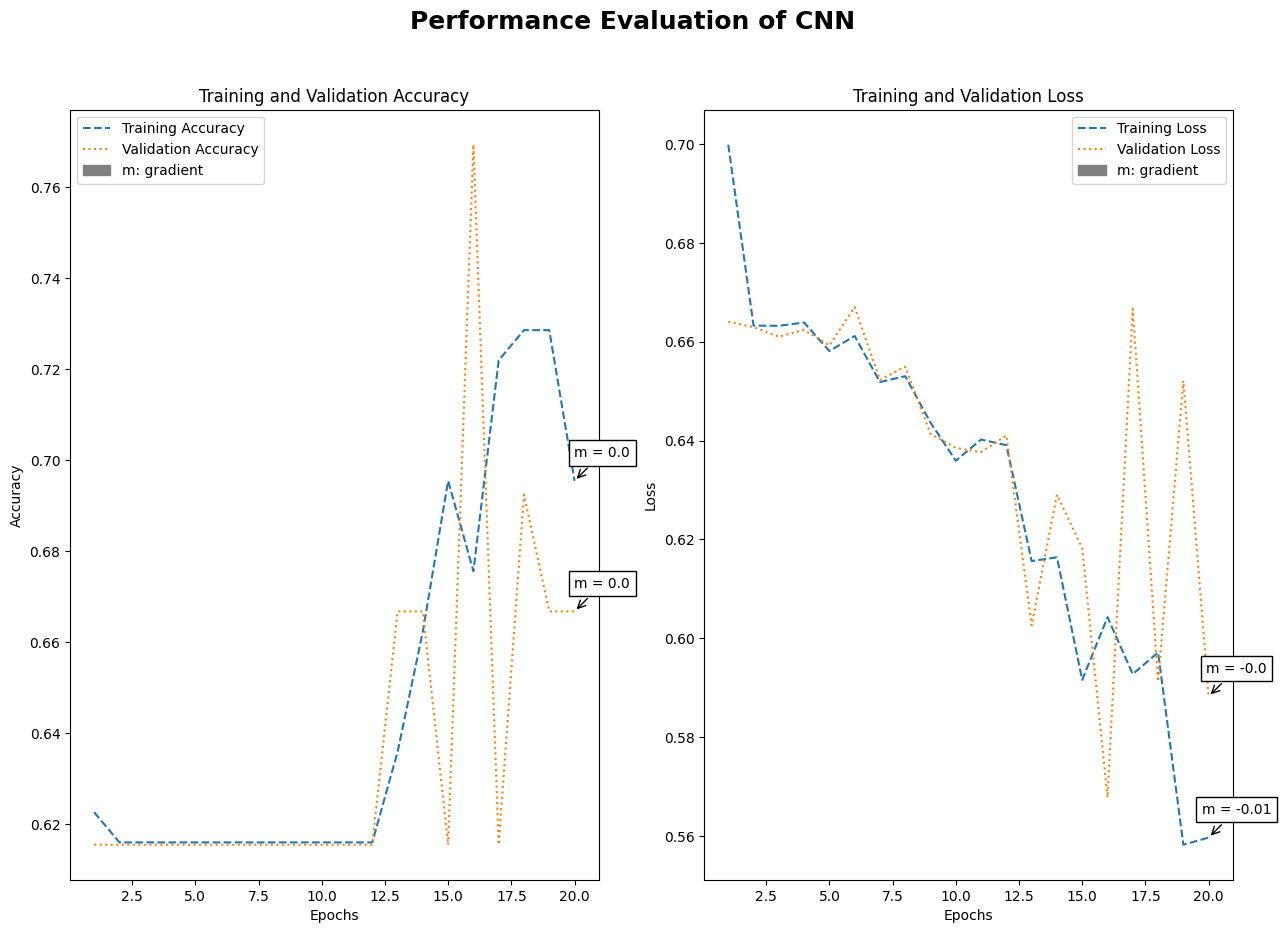

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import TextArea, AnnotationBbox

# Get the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_accuracy) + 1)

def get_gradient(y_arr, epochs):
    return round((y_arr[-1] - y_arr[0]) / (epochs[-1] - epochs[0]), 2)

def vis_evaluation(history_dict, model_name):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

    def vis_sub_evaluation(n, metric_name, train_metric, val_metric):
        axs[n].plot(epochs, train_metric, label=f'Training {metric_name}', ls='--')
        axs[n].plot(epochs, val_metric, label=f'Validation {metric_name}', ls='dotted')
        axs[n].set_title(f'Training and Validation {metric_name}')
        axs[n].set_xlabel('Epochs')
        axs[n].set_ylabel(metric_name)
        handles, labels = axs[n].get_legend_handles_labels()
        m_patch = mpatches.Patch(color='grey', label='m: gradient')
        handles.append(m_patch)
        axs[n].legend(handles=handles)

        def annotate_box(metric_arr):
            return AnnotationBbox(TextArea(f"m = {get_gradient(metric_arr, epochs)}"), (epochs[-1], metric_arr[-1]), xybox=(20, 20), xycoords='data', boxcoords="offset points", arrowprops=dict(arrowstyle="->"))

        axs[n].add_artist(annotate_box(train_metric))
        axs[n].add_artist(annotate_box(val_metric))

    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    vis_sub_evaluation(0, 'Accuracy', train_acc, val_acc)

    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    vis_sub_evaluation(1, 'Loss', train_loss, val_loss)

    plt.suptitle(f"Performance Evaluation of {model_name}", fontsize=18, fontweight='bold')
    plt.show()

# Assuming you've already trained the model and have the history object
history_dict_1 = history.history
vis_evaluation(history_dict_1, 'CNN')

In [ ]:
# Define MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Get the output tensor from the base model
last_output = base_model.output

# Calculate the number of trainable parameters
num_trainable_params = sum([w.shape.num_elements() for w in base_model.trainable_weights])

# Print information about the model
print(f"There are {num_trainable_params:,} trainable parameters in this model.")
print(f"The pretrained model has type: {type(base_model)}")

9406464/9406464 [==============================] - 1s 0us/step
There are 0 trainable parameters in this model.
The pretrained model has type: <class 'keras.src.engine.functional.Functional'>


In [ ]:
def transfer_learning(last_output, pre_trained_model):
    # Flatten the output layer to 1 dimension
    x = tf.keras.layers.Flatten()(last_output)
    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.6
    x = tf.keras.layers.Dropout(0.6)(x)
    # Add a final sigmoid layer for classification
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    # Create the complete model by using the Model class
    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

    return model

# Create the transfer learning model
model = transfer_learning(last_output, base_model)

# Display the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']      

In [ ]:
# Assuming you have already initialized train and val data generators
# train and val are your ImageDataGenerators with shape (256, 256, 3)

# Define MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Get the output tensor from the base model
last_output = base_model.output

# Function to add custom layers for transfer learning
def transfer_learning(last_output, pre_trained_model):
    # Flatten the output layer to 1 dimension
    x = tf.keras.layers.Flatten()(last_output)
    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.6
    x = tf.keras.layers.Dropout(0.6)(x)
    # Add a final sigmoid layer for classification
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    # Create the complete model by using the Model class
    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

    return model

# Create the transfer learning model
model = transfer_learning(last_output, base_model)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0003),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
callback = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(train,
                    epochs=10,
                    validation_data=val,
                    callbacks=[callback])

Epoch 1/10
3/3 [==============================] - 12s 2s/step - loss: 5.3313 - accuracy: 0.6026 - val_loss: 1.0548 - val_accuracy: 0.8718
Epoch 2/10
3/3 [==============================] - 3s 1s/step - loss: 2.2326 - accuracy: 0.7351 - val_loss: 1.2493 - val_accuracy: 0.8205
Epoch 3/10
3/3 [==============================] - 4s 2s/step - loss: 0.9759 - accuracy: 0.9073 - val_loss: 0.9830 - val_accuracy: 0.8462
Epoch 4/10
3/3 [==============================] - 4s 2s/step - loss: 1.1020 - accuracy: 0.8344 - val_loss: 1.0601 - val_accuracy: 0.8974
Epoch 5/10
3/3 [==============================] - 3s 1s/step - loss: 1.7624 - accuracy: 0.7947 - val_loss: 1.5214 - val_accuracy: 0.8718
Epoch 6/10
3/3 [==============================] - 4s 2s/step - loss: 0.4036 - accuracy: 0.9338 - val_loss: 2.3350 - val_accuracy: 0.7692


In [ ]:
# Evaluate the model on validation data
loss, accuracy = model.evaluate(val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

1/1 [==============================] - 1s 681ms/step - loss: 2.1242 - accuracy: 0.7436
Validation Loss: 2.1242117881774902
Validation Accuracy: 0.7435897588729858


In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Total Trainable Variables: {len(model.trainable_variables)}")

Number of layers in the base model:  154
Total Trainable Variables: 58


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001/10),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [ ]:
history_fine = model.fit(train,
                         epochs=15,
                         initial_epoch=history.epoch[-1],
                         validation_data=val)

Epoch 6/15
3/3 [==============================] - 4s 2s/step - loss: 0.6294 - accuracy: 0.8874 - val_loss: 1.4797 - val_accuracy: 0.8205
Epoch 7/15
3/3 [==============================] - 4s 2s/step - loss: 0.4018 - accuracy: 0.9007 - val_loss: 1.0824 - val_accuracy: 0.8974
Epoch 8/15
3/3 [==============================] - 3s 1s/step - loss: 0.5487 - accuracy: 0.8742 - val_loss: 2.0334 - val_accuracy: 0.7436
Epoch 9/15
3/3 [==============================] - 3s 1s/step - loss: 0.5549 - accuracy: 0.8940 - val_loss: 1.4803 - val_accuracy: 0.8718
Epoch 10/15
3/3 [==============================] - 3s 1s/step - loss: 0.5587 - accuracy: 0.9139 - val_loss: 1.2548 - val_accuracy: 0.8462
Epoch 11/15
3/3 [==============================] - 3s 1s/step - loss: 0.3694 - accuracy: 0.9205 - val_loss: 1.7338 - val_accuracy: 0.7949
Epoch 12/15
3/3 [==============================] - 3s 1s/step - loss: 0.3448 - accuracy: 0.9073 - val_loss: 1.9642 - val_accuracy: 0.8205
Epoch 13/15
3/3 [=====================

In [ ]:
loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 1s/step - loss: 1.6229 - accuracy: 0.8413
Test accuracy : 0.841269850730896


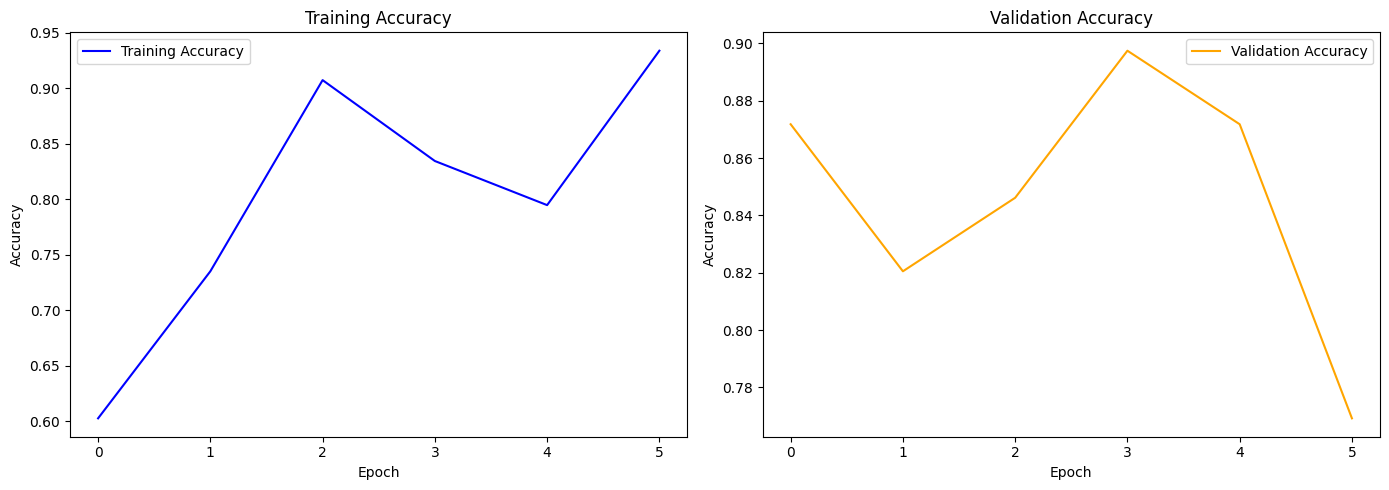

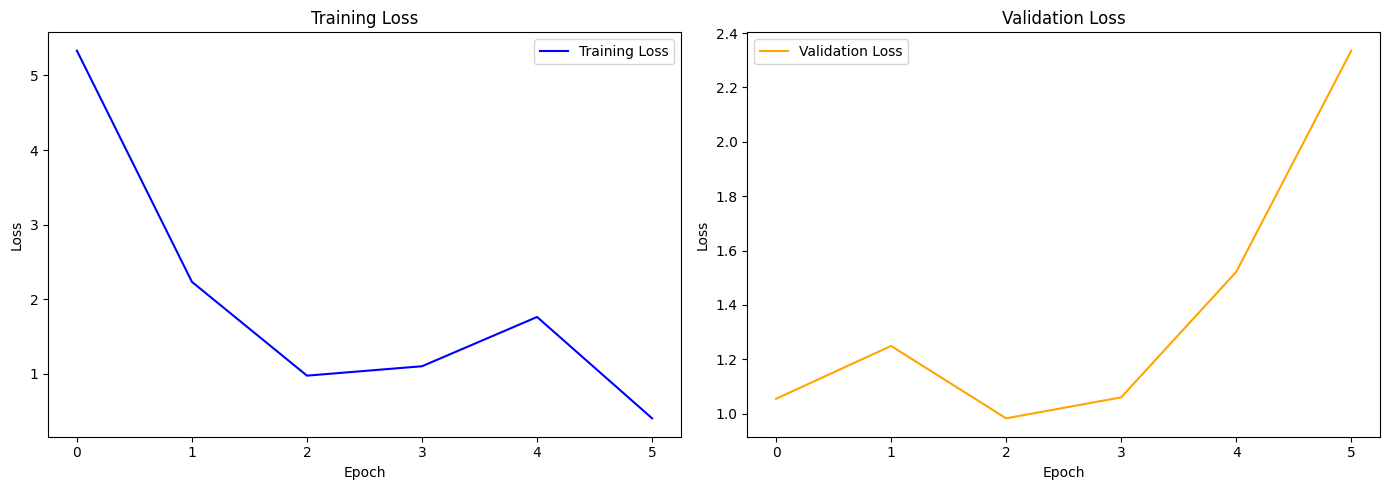

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()


# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Plot training and validation loss
plt.figure(figsize=(14, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

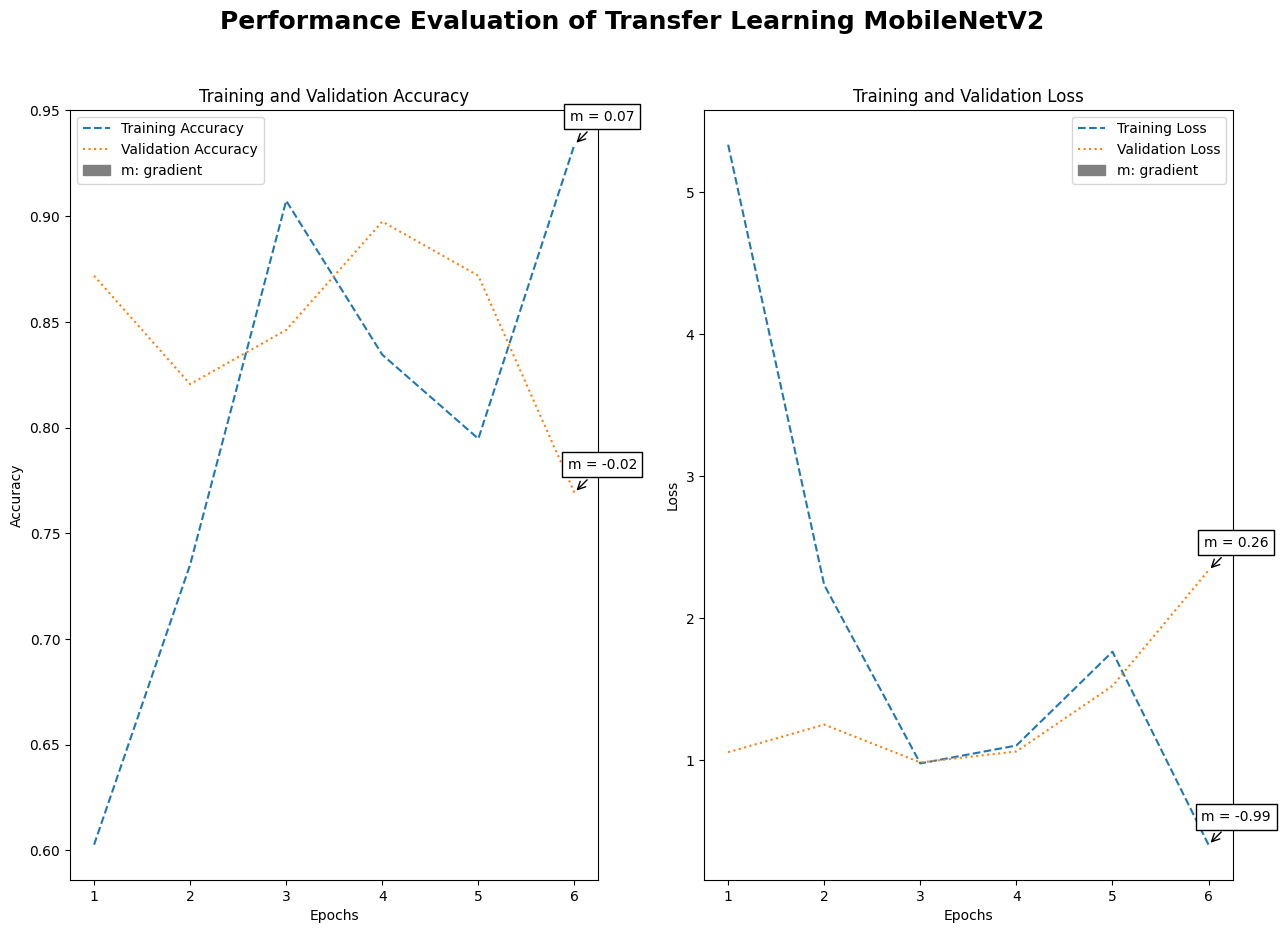

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import TextArea, AnnotationBbox
import numpy as np

def vis_evaluation(history_dict, model_name):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    epochs = range(1, len(history_dict['accuracy']) + 1)

    def get_gradient(y_arr, epochs):
        return round((y_arr[-1] - y_arr[0]) / (epochs[-1] - epochs[0]), 2)

    def vis_sub_evaluation(n, Accuracy, train_acc, val_acc, epochs):
        axs[n].plot(epochs, train_acc, label=f'Training {Accuracy}', ls='--')
        axs[n].plot(epochs, val_acc, label=f'Validation {Accuracy}', ls='dotted')

        axs[n].set_title(f'Training and Validation {Accuracy}')
        axs[n].set_xlabel('Epochs')
        axs[n].set_ylabel(Accuracy)

        handles, labels = axs[n].get_legend_handles_labels()
        m_patch = mpatches.Patch(color='grey', label='m: gradient')
        handles.append(m_patch)
        axs[n].legend(handles=handles)

        def annotate_box(train_acc):
            return AnnotationBbox(TextArea(f"m = {get_gradient(train_acc, epochs)}"), (epochs[-1], train_acc[-1]),
                            xybox=(20, 20),
                            xycoords='data',
                            boxcoords="offset points",
                            arrowprops=dict(arrowstyle="->"))
        axs[n].add_artist(annotate_box(train_acc))
        axs[n].add_artist(annotate_box(val_acc))

    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    vis_sub_evaluation(0, 'Accuracy', train_acc, val_acc, epochs)

    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    vis_sub_evaluation(1, 'Loss', train_loss, val_loss, epochs)

    plt.suptitle(f"Performance Evaluation of {model_name}", fontsize=18, fontweight='bold')
    plt.show()

# Assuming you've already trained the model and have the history object
history_dict_1 = history.history
vis_evaluation(history_dict_1, 'Transfer Learning MobileNetV2')


In [ ]:
learning_rate = 0.001
base_model = Xception(weights='imagenet', include_top=False, pooling='max')
x = base_model.output
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

optimizer = Adamax(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train, epochs=150, validation_data=val)

83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/150
3/3 [==============================] - 58s 8s/step - loss: 0.8536 - accuracy: 0.6556 - val_loss: 0.6080 - val_accuracy: 0.7179
Epoch 2/150
3/3 [==============================] - 6s 2s/step - loss: 0.4165 - accuracy: 0.8146 - val_loss: 0.4502 - val_accuracy: 0.8205
Epoch 3/150
3/3 [==============================] - 5s 1s/step - loss: 0.2889 - accuracy: 0.9007 - val_loss: 0.4227 - val_accuracy: 0.8718
Epoch 4/150
3/3 [==============================] - 5s 2s/step - loss: 0.1315 - accuracy: 0.9338 - val_loss: 0.5240 - val_accuracy: 0.7692
Epoch 5/150
3/3 [==============================] - 5s 1s/step - loss: 0.0630 - accuracy: 0.9801 - val_loss: 0.9828 - val_accuracy: 0.6923
Epoch 6/150
3/3 [==============================] - 5s 2s/step - loss: 0.1101 - accuracy: 0.9536 - val_loss: 1.1872 - val_accuracy: 0.5897
Epoch 7/150
3/3 [==============================] - 5s 1s/step - loss: 0.1368 - accuracy: 0.9470 - val_loss

In [ ]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 [==============================] - 8s 8s/step - loss: 0.4534 - accuracy: 0.9206
Test Loss: 0.4534203112125397
Test Accuracy: 0.920634925365448


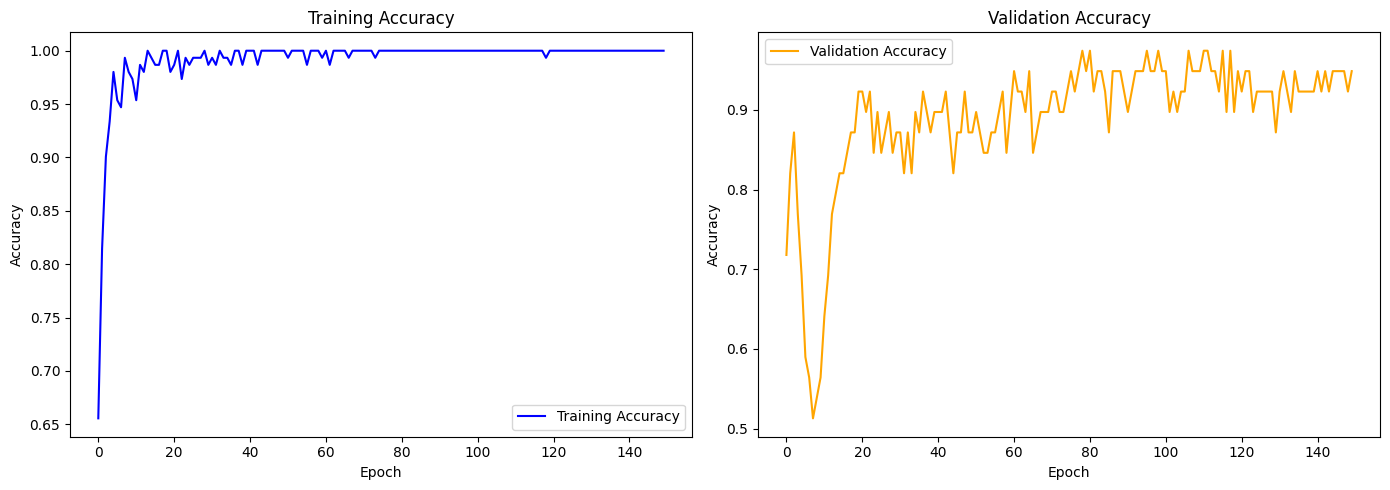

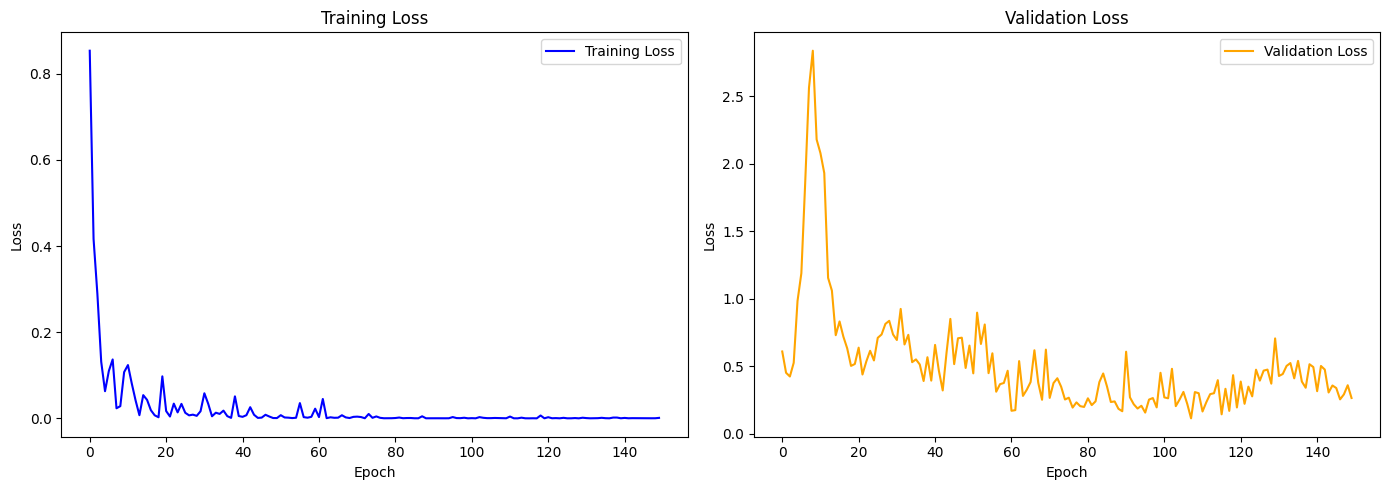

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()


# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Plot training and validation loss
plt.figure(figsize=(14, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()